# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work. 

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it.

### Data of choice: Motorcycles in the DMV

Because there weren't a ton of listings in Charlottesville, I expanded the location to include much of the DMV.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} 
url = 'https://fredericksburg.craigslist.org/search/culpeper-va/mca?lat=38.4364&lon=-77.97&search_distance=132#search=1~gallery~0~0' 
raw = requests.get(url,headers=header) # Get page

## 2. Get your search results of interest and extract data from them, using code similar to what's above.

### Web scraping

- Used a link that includes motorcycle listings in much of the DMV
- Elements scraped from each listing:
    - Title
    - Link
    - Price
    - Brand
    - Year
    - Location (Got by splitting link)
- Used a list of motorycle brands, looking for matches to set brand. Similar to sample code, but searches the title, and if any of the words in the title are in any of the brands of the brands array (partial matches), the brand is set to the brand in the array. For example, the title "Harley bike brand new 2008" would have the brand set to "harley-davidson" even though it is not an exact match.

In [3]:

from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

import re # Regular expressions

brands = ['harley-davidson', 'yamaha', 'honda', 'ducati', 'kawasaki', 
                    'suzuki', 'bmw motorrad', 'triumph', 'ktm', 'indian motorcycle', 
                    'aprilia', 'moto guzzi', 'mv agusta', 'royal enfield', 
                    'husqvarna', 'benelli', 'bajaj', 'hero motocorp', 
                    'cfmoto', 'bimota']


data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    domain = link.split('/')[2]
    location = domain.split('.')[0]
    # Get brand from the title string:
    words = title.lower().split()  
    hits = [brand for brand in brands if any(word in brand for word in words)]
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]  # The first matching brand
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan 
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand,'location':location})


## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.

In [23]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_DMV_motorcycles.csv') # Save data in case of a disaster
df.head()

(348, 7)


,title,price,year,link,brand,location,age
0,victory trike,7900,NaN,https://frederick.craigslist.org/mcy/d/thurmon...,missing,frederick,NaN
1,2023 honda xr150l,3250,2023.0,https://richmond.craigslist.org/mcy/d/glen-all...,honda,richmond,2.0
2,2020 indian roadmaster dark horse,17000,2020.0,https://washingtondc.craigslist.org/nva/mcy/d/...,indian motorcycle,washingtondc,5.0
3,"2023 royal enfield meteor 350, hunter and scra...",0,2023.0,https://norfolk.craigslist.org/mcd/d/newport-n...,harley-davidson,norfolk,2.0
4,"2022 can-am ryker - low miles, save big over a...",7999,2022.0,https://norfolk.craigslist.org/mcd/d/newport-n...,harley-davidson,norfolk,3.0


#### Visualizations:
- Distribution of motorcycle prices
- Distribution of motorcycle ages
- 10 most common motorcycle brands
- Scatterplot comparing price with age and brand
- Box plots comparing price with location of listing

#### Other EDA:
- Describe price and brand



count      348.000000
mean      6971.367816
std       6194.631602
min          0.000000
25%       3000.000000
50%       5450.000000
75%       8500.000000
max      37500.000000
Name: price, dtype: float64


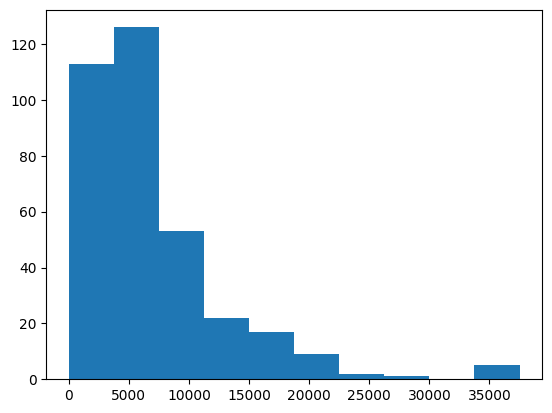

count    262.000000
mean      19.465649
std       15.632905
min        0.000000
25%        8.000000
50%       16.000000
75%       23.750000
max       76.000000
Name: age, dtype: float64


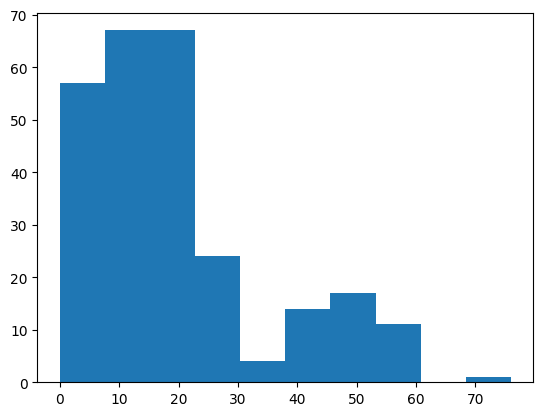

In [6]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [7]:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                      \
                   count         mean           std     min      25%     50%   
brand                                                                          
bajaj                1.0  1500.000000           NaN  1500.0  1500.00  1500.0   
bmw motorrad        13.0  6901.153846   5874.178380     1.0  2495.00  5900.0   
ducati               4.0  5174.750000   2724.080931  1700.0  3800.00  5500.0   
harley-davidson    103.0  8431.747573   4911.235344     0.0  5000.00  6750.0   
honda               58.0  7641.810345  10164.234885     0.0  2725.00  4047.5   
husqvarna            1.0  5400.000000           NaN  5400.0  5400.00  5400.0   
indian motorcycle    7.0  8013.571429   5613.655014  3200.0  4200.00  6000.0   
kawasaki            17.0  4174.882353   2453.075286  1895.0  2590.00  3800.0   
ktm                  4.0  7862.250000   2672.427158  5000.0  6275.00  7599.5   
missing             75.0  7222.066667   6219.711152    25.0  1750.00  6500.0   
suzuki              22.0  4042.500000   2397.150963   995.0  2421.25  3100.0   
triumph             11.0  7536.363636   2590.858054  5300.0  6000.00  6500.0   
yamaha              32.0  3906.875000   2786.268967   995.0  1650.00  3525.0   

                                      
                        75%      max  
brand                                 
bajaj               1500.00   1500.0  
bmw motorrad        8499.00  18950.0  
ducati              6874.75   7999.0  
harley-davidson    10900.00  21500.0  
honda               6300.00  37500.0  
husqvarna           5400.00   5400.0  
indian motorcycle  10747.50  17000.0  
kawasaki            4998.00  12500.0  
ktm                 9186.75  11250.0  
missing            10000.00  27500.0  
suzuki              5800.00   9300.0  
triumph             7500.00  13500.0  
yamaha              4825.00  13900.0

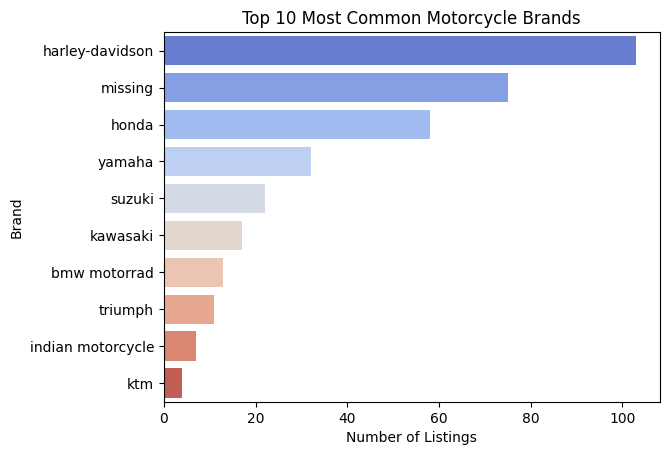

Correlation Coefficient: -0.3611889298053057


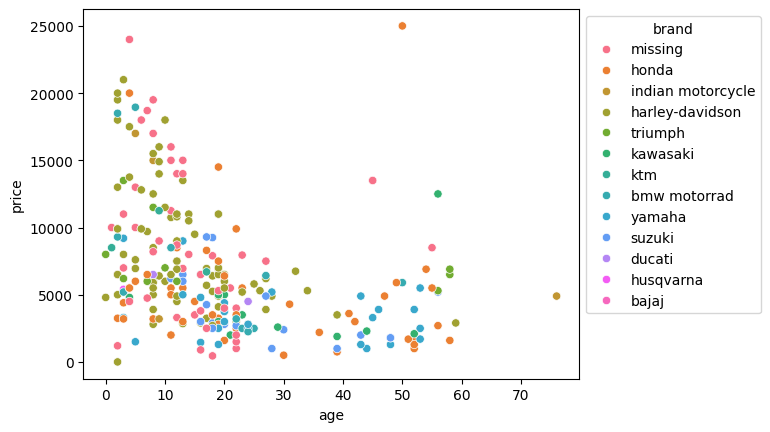

In [25]:
top_brands = df['brand'].value_counts().head(10)
sns.barplot(x=top_brands.values, y=top_brands.index, hue=top_brands.index, palette='coolwarm')
plt.title('Top 10 Most Common Motorcycle Brands')
plt.xlabel('Number of Listings')
plt.ylabel('Brand')
plt.show()

ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print("Correlation Coefficient:",df['price'].corr(df['age']))

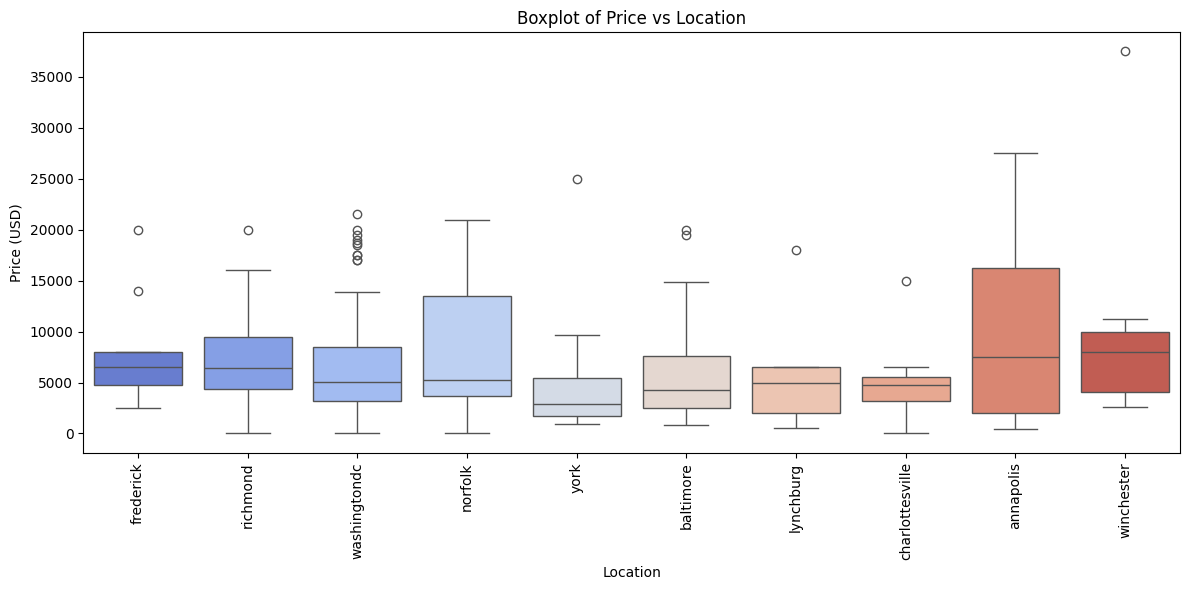

In [21]:
top_locations = df['location'].value_counts().index[:10]

# Filter the data for those top locations
df_filtered = df[df['location'].isin(top_locations)]

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x='location', hue='location', y='price', palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Boxplot of Price vs Location')
plt.xlabel('Location')
plt.ylabel('Price (USD)')
plt.tight_layout()
plt.show()

### Observations

- The vast majority of listed motorcycles are under $10,000 and less than 20 years old
- The most common brand listed by far is Harley-Davidson
- There is some correlation between price and age, moderate negative correlation at -0.36. 
- There doesn't seem to be much of a correlation between price and location of listing